# Lab 7 - Multilabel Classification

Plan for today:

* familiarize ourselves with the problem of multilabel classification and metrics for such modelling
* implement two multilabel classification methods:
  * one-vs-all
  * embedding-based

**Attention!** We will work with [MS-COCO](https://cocodataset.org/) dataset today. It's pretty large, so we strongly recommend working with Colab today, since it'll be quicker to download the dataset there.

In [1]:
import json
from typing import List, Dict
import torch
from torch import nn
from torchvision.datasets import CocoDetection
from torchvision.models import vgg16, resnet34
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models import vgg16

## 1 - The problem of Multilabel classification

In the problem of Multilabel classification, we would like to predict a **set** of labels for a given example.

**Question**: why do you think the softmax-based approach is not the best for this scenario?

**YOUR ANSWER HERE**

Multilabel solutions performance will also be measured a bit differently than in regular classification settings:

#### Precision

$$
  \frac{|y \cap \hat{y}|}{|\hat{y}|}
$$

#### Recall

$$
  \frac{|y \cap \hat{y}|}{|y|}
$$

#### F1-score
* the harmonic average of precision and recall

### Task for you - please implement precision and recall for multilabel classification



In [2]:

def precision(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Both y_true and y_pred should be tensors of ones and zeros of shape [B, C]
    denoting if an object of given class is or isn't present in the photo.
    """
    true_positives = (y_true * y_pred).sum(dim=0).float()
    predicted_positives = y_pred.sum(dim=0).float()

    precision_per_class = true_positives / (predicted_positives + 1e-8)
    precision_per_class[torch.isnan(precision_per_class)] = 0

    return precision_per_class.mean().item()

def recall(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Both y_true and y_pred should be tensors of ones and zeros of shape [B, C]
    denoting if an object of given class is or isn't present in the photo.
    """
    true_positives = (y_true * y_pred).sum(dim=0).float()
    actual_positives = y_true.sum(dim=0).float()

    recall_per_class = true_positives / (actual_positives + 1e-8)
    recall_per_class[torch.isnan(recall_per_class)] = 0

    return recall_per_class.mean().item()

## 2 - Data setup and exploration

Today we will work with the [COCO dataset](https://cocodataset.org/#home). Let's download it - in Colab it should take a couple of minutes:

In [3]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2024-05-29 21:34:35--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.10.204, 3.5.28.218, 3.5.3.117, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.10.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  53.0MB/s    in 4m 12s  

2024-05-29 21:38:47 (51.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [4]:
!unzip train2014.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train2014/

In [5]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2024-05-29 21:41:44--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.131, 52.217.233.201, 3.5.25.68, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  53.3MB/s    in 5.0s    

2024-05-29 21:41:49 (48.5 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]



In [6]:
!unzip annotations_trainval2014.zip

Archive:  annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [7]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2024-05-29 21:42:03--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.203.65, 54.231.198.241, 52.217.230.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.203.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  51.1MB/s    in 2m 2s   

2024-05-29 21:44:05 (51.9 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [8]:
!unzip val2014.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_

In [9]:
with open("annotations/instances_train2014.json") as f:
  annot = json.load(f)

categories_names = {
    c["id"]: c["name"]
    for c in annot["categories"]
}

In [10]:
max([an["category_id"] for an in annot["annotations"] ])

90

COCO is an object detection dataset. However, today we will be only interested in labels of the objects present in the photos.

In [11]:
def instances_to_multilabel_vector(instances: List[dict], vector_size: int = 91):
  vector = torch.zeros(vector_size)
  for i in instances:
    vector[i["category_id"]] = 1
  return vector

In [12]:
train_set = CocoDetection(
    root="train2014", annFile="annotations/instances_train2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=T.Compose([
            T.Resize(224),
            # Feel free to add augmentation!
            T.ToTensor(),
            T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          )
      ])
    )

val_set = CocoDetection(
    root="val2014", annFile="annotations/instances_val2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=T.Compose([
            T.Resize(224),
            T.ToTensor(),
            T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          )
      ])
    )

loading annotations into memory...
Done (t=17.71s)
creating index...
index created!
loading annotations into memory...
Done (t=8.59s)
creating index...
index created!


Let's examine the data:

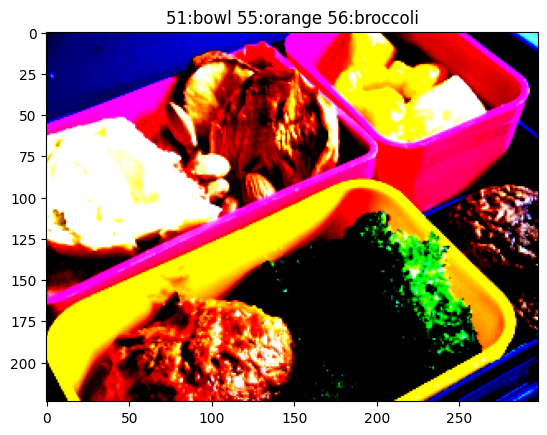

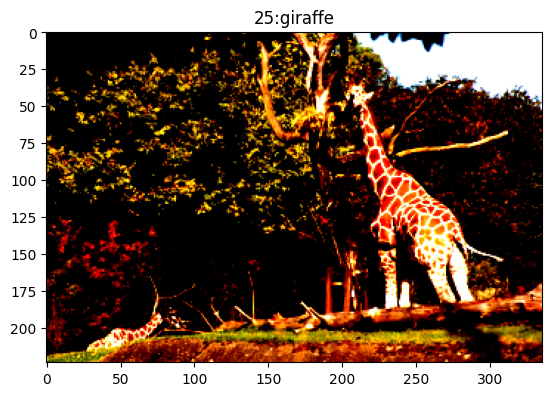

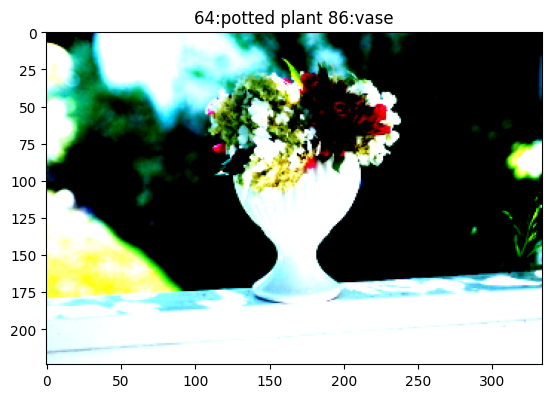

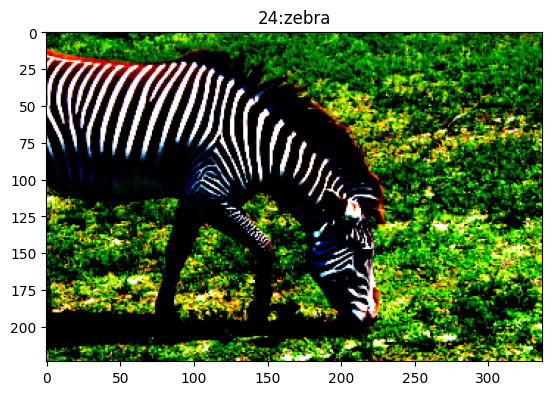

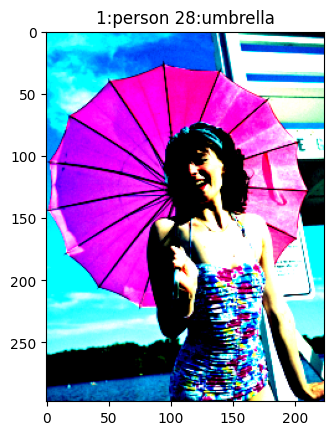

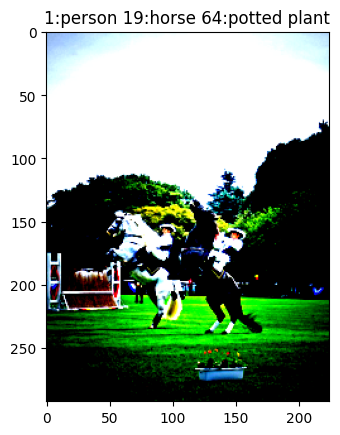

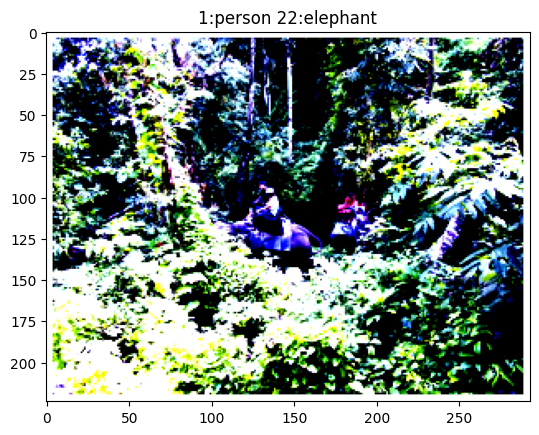

In [13]:
for i, (X, y) in enumerate(train_set):

  plt.imshow(
      X.permute(1,2,0)
      # we're dealing with images transformed to tensors
      # so in order to view them we need to permute them.
  )

  cats = [f"{i}:{categories_names[i]}" for i, oh in enumerate(y) if oh==1]
  plt.title(" ".join(cats))
  plt.show()

  if i > 5:
    break

When working with multilabel problems, it is often useful to analyze the data and see which labels tend to co-appear with one another.

For example, humans may commonly appear together with dogs, but girraffes are unlikely to co-appear with umbrellas.

### Task for you - analyze the co-existence of labels

* go through the training dataset
* count the number of co-appearances of each **pair** of labels
* print the top-10 most commonly co-appearing label pairs, along with their class IDs and names (names are provided in the `categories_names` dict)
* you can also draw a heatmap of all co-occurences
* **note** - please avoid redundancy - e.g. if you count appearances of the `(A, B)` pair, you don't need to also count appearances of the `(B, A)` pair.


In [15]:
import seaborn as sns
import numpy as np
# Load COCO annotations
with open("annotations/instances_train2014.json") as f:
    annot = json.load(f)

# Create a mapping from category ID to category name
categories_names = {c["id"]: c["name"] for c in annot["categories"]}

# Define the function to convert instance annotations to a multilabel vector
def instances_to_multilabel_vector(instances, vector_size=91):
    vector = torch.zeros(vector_size)
    for instance in instances:
        vector[instance["category_id"]] = 1
    return vector

# Define the train set
train_set = CocoDetection(
    root="train2014", annFile="annotations/instances_train2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=T.Compose([
            T.Resize(224),
            # Feel free to add augmentation!
            T.ToTensor(),
            T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          )
      ])
)

# Initialize co-occurrence matrix
num_classes = len(categories_names)
co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Iterate through the training dataset and count co-occurrences
for _, target in train_set:
    target = target.numpy().astype(int)
    indices = np.where(target == 1)[0]
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            co_occurrence_matrix[indices[i], indices[j]] += 1

# Extract the top-10 most commonly co-appearing label pairs
co_occurrence_pairs = []
for i in range(num_classes):
    for j in range(i + 1, num_classes):
        if co_occurrence_matrix[i, j] > 0:
            co_occurrence_pairs.append((co_occurrence_matrix[i, j], i, j))

co_occurrence_pairs = sorted(co_occurrence_pairs, reverse=True)[:10]

# Print the top-10 most commonly co-appearing label pairs
print("Top-10 most commonly co-appearing label pairs:")
for count, i, j in co_occurrence_pairs:
    print(f"Count: {count}, Class IDs: ({i}, {j}), Names: ({categories_names[i]}, {categories_names[j]})")

# Draw a heatmap of all co-occurrences
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap="YlGnBu")
plt.title("Co-occurrence Matrix of COCO Labels")
plt.xlabel("Class ID")
plt.ylabel("Class ID")
plt.show()

loading annotations into memory...
Done (t=16.05s)
creating index...
index created!


IndexError: index 86 is out of bounds for axis 1 with size 80

## 2 - One-vs-all classification

One way to approach multi-label classification is to treat it as $N$ binary classifications - take a model which outputs $N$ labels, but instead of applying $softmax$ as the final activation, applies $sigmoid$ function.

We can train such models with the [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

### Task for you - train a model with one-vs-all method
* report the previously implemented precision and recall on the validation set throughout the training
* note that the grond-truth label vectors and output label vectors must hve the same dimentionality (91).
* note that precision and recall expect the vectors of `0`'s and `1`'s - therefore, when calculating those metrics, you need to transform the sigmoid output to such format!

**Hint**:

In order to simplify the training, you can take a pre-trained model from torchvision, e.g. VGG or ResNet and replace it's final layer with a linear layer with the appropriate number of classes (91), followed by sigmoid.


In [16]:
model = vgg16(pretrained=True)
model.classifier[-1] = nn.Sequential(
    nn.Linear(model.classifier[-1].in_features, 91),
    nn.Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 35.7MB/s]


In [17]:
# YOUR CODE WITH THE TRAINING LOOP SHOULD GO HERE
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
# Load COCO dataset
train_set = CocoDetection(
    root="train2014", annFile="annotations/instances_train2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)
val_set = CocoDetection(
    root="val2014", annFile="annotations/instances_val2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# Define data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Initialize pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Sequential(
    nn.Linear(model.classifier[-1].in_features, 91),
    nn.Sigmoid()
)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_set)

    # Validation
    model.eval()
    val_precision = 0.0
    val_recall = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            outputs_binary = (outputs > 0.5).float()
            val_precision += precision(targets.cpu().numpy(), outputs_binary.cpu().numpy()) * images.size(0)
            val_recall += recall(targets.cpu().numpy(), outputs_binary.cpu().numpy()) * images.size(0)

    val_precision /= len(val_set)
    val_recall /= len(val_set)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
    model.train()

loading annotations into memory...
Done (t=18.83s)
creating index...
index created!
loading annotations into memory...
Done (t=10.92s)
creating index...
index created!


RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 336] at entry 0 and [3, 224, 224] at entry 1

## 3 - Taking advantage of class correlations

The sigmoid classifies each label **separately**. Even though it's internal features may in practice learn to associate two labels together, we can force it to do this explicitly.

For this approach we'll need 3 networks:
* $F_X$ - transforms images $x$ into embeddings $E_X$
* $F_Y$ - transforms label vectors $y$ into embeddings $E_Y$
* $F_D$ - transforms embeddings $E_X$ into predictions $Y_p$

The embeddings $E_X$ and $E_Y$ are of equal latent dimentionality $l$, possibly lower than $c$ (number of classes).


The models will optimize the sum of three loss functions:

1. We want the embeddings of pictures with a set of labels to be similiar to the embeddings of that set of labels:
$$
L1 = \|F_X(x) - F_Y(y) \|^2 =\\
\|E_X - E_Y\|^2
$$

2. We want the embeddings to be ortonormal (lengths of 1 and each pair of embedding vectors should be orthogonal to its transposed version). Similarly to what happens in self-supervised learning, this prevents the representations from collapsing due to $L1$.

$$
L2 = \|F_X(X)F_X(X)^T - I\|^2 + \|F_Y(Y)F_Y(Y)^T - I\|^2  = \\
\|E_X E_X^T - I \|^2 + \|E_Y E_Y^T - I \|^2
$$

where $I \in \mathbb{R}^{l \times l} $ (see Eq. 2 of [this paper](https://ojs.aaai.org/index.php/AAAI/article/view/10769/10628) ).

3. We want to decode the predicted labels from the embeddings:

$$
L3 = \| F_D(F_X(x)) - y \|^2 = \\
\| F_D(E_X) - y \|^2
$$

By minimizing $L1 + L2$, we obtain **C**anonical **C**orrelation **A**nalyis. Minimizing $L3$ lets us decode the obtained embeddings.

### Task for you - train a model with the embedding-based method

* implement $L1, L2, L3$ losses and the training loop
* report the previously implemented precision and recall on the validation set throughout the training
* for obtaining embeddings, use the same kind of model as before, but replace the final layer with linear layer with your chosen embedding size
* networks $F_Y$ and $F_D$ should be sequences of a couple of linear layers

In [18]:
def l1(e_x, e_y):
  """
  e_x, e_y: tensors of shape [b, embedding_size]
  """
  return torch.mean((e_x - e_y) ** 2)


def l2(e_x, e_y, embedding_size):
  return torch.mean((torch.matmul(e_x, torch.transpose(e_x, 0, 1)) - torch.eye(embedding_size)) ** 2) + \
      torch.mean((torch.matmul(e_y, torch.transpose(e_y, 0, 1)) - torch.eye(embedding_size)) ** 2)


def l3(y_true, y_pred):
  return torch.mean((y_pred - y_true) ** 2)


In [19]:
# Load COCO dataset
train_set = CocoDetection(
    root="train2014", annFile="annotations/instances_train2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)
val_set = CocoDetection(
    root="val2014", annFile="annotations/instances_val2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# Define data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Initialize pre-trained VGG16 model for embeddings
embedding_size = 128
model_X = models.vgg16(pretrained=True)
model_X.classifier[-1] = nn.Linear(model_X.classifier[-1].in_features, embedding_size)

# Define model for label embeddings
model_Y = nn.Sequential(
    nn.Linear(91, 64),
    nn.ReLU(),
    nn.Linear(64, embedding_size),
)

# Define model for decoding embeddings
model_D = nn.Sequential(
    nn.Linear(embedding_size, 64),
    nn.ReLU(),
    nn.Linear(64, 91),
    nn.Sigmoid()
)

# Define optimizer
params = list(model_X.parameters()) + list(model_Y.parameters()) + list(model_D.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

loading annotations into memory...
Done (t=16.52s)
creating index...
index created!
loading annotations into memory...
Done (t=8.55s)
creating index...
index created!


In [20]:
# YOUR CODE WITH THE TRAINING LOOP SHOULD GO HERE
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_X.to(device)
model_Y.to(device)
model_D.to(device)

for epoch in range(num_epochs):
    model_X.train()
    model_Y.train()
    model_D.train()

    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        embeddings_X = model_X(images)
        embeddings_Y = model_Y(targets)
        outputs = model_D(embeddings_X)

        # Calculate losses
        loss1 = l1(embeddings_X, embeddings_Y)
        loss2 = l2(embeddings_X, embeddings_Y)
        loss3 = l3(targets, outputs)
        loss = loss1 + loss2 + loss3

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_set)

    # Validation
    model_X.eval()
    model_Y.eval()
    model_D.eval()

    val_precision = 0.0
    val_recall = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)

            embeddings_X = model_X(images)
            embeddings_Y = model_Y(targets)
            outputs = model_D(embeddings_X)

            outputs_binary = (outputs > 0.5).float()
            val_precision += precision(targets.cpu().numpy(), outputs_binary.cpu().numpy()) * images.size(0)
            val_recall += recall(targets.cpu().numpy(), outputs_binary.cpu().numpy()) * images.size(0)

    val_precision /= len(val_set)
    val_recall /= len(val_set)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 335] at entry 0 and [3, 298, 224] at entry 1